In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
from imports import *

/fabian/env/work/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/fabian/env/work/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/fabian/env/work/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
T = 2

sample_batch_size = 1000 #@param {'type':'integer'}

dataset_str = "MNIST" #@param ['LIDC', 'MNIST'] {'type':'string'}

eps = 1e-3
device = "cuda"

inv_prob = "ct"#@param ['ct', 'deblurr'] {'type':'string'}

## Parameters below are fixed for our experiment. Changing them will require training a new model for our approach.
sig_blurr = 4
sig_obs = 0.05

max_angle = 15

#prepare forward map and other required parameters
if dataset_str == "MNIST":
    from custom_configs import MNIST_ddpmpp_continuous as configs  
        

In [3]:
# @title Load the score-based model
config = configs.get_config()

size = config.data.image_size

random_seed = 1 #@param {"type": "integer"}
torch.manual_seed(random_seed)

uncond_score_model = mutils.create_model(config)
our_score_model = mutils.create_model(config)

color_channels = config.data.num_channels

angles = int(size * max_angle / 180.)

device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}

torch.manual_seed(random_seed)

#prepare forward map and other required parameters
if dataset_str == "MNIST":
    from torchvision.datasets import MNIST
    num_steps = 1000
    dataset = MNIST('.', 
                train=False, 
                transform=torchvision.transforms.Compose(
                    [torchvision.transforms.Resize(32), torchvision.transforms.ToTensor()]),
                download=True)
    data_loader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=4)

#prepare forward map and other required parameters
if inv_prob == "deblurr":
    from utils_ours import build_blurring_operator
    A = build_blurring_operator(size, sig_blurr).to(device)
    Gamma = sig_obs * torch.eye(size**2).to(device)
elif inv_prob == "ct":
    from utils_ours import build_CT_operator
    try:
        A = torch.load("CT_forward" + str(size) + "angles" + str(angles) + "max_angle" + str(max_angle) +".pt")
    except:
        A = build_CT_operator(size, angles, max_angle)
    A = torch.from_numpy(A)
    Gamma = sig_obs * torch.eye(size*angles).to(device)
    
Gam_inv = torch.linalg.inv(Gamma)

## Generate Measurement

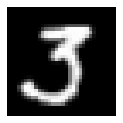

In [4]:
true, label = next(iter(data_loader))
true = true.cuda()

sample_grid = make_grid(true, nrow=1)

plt.figure(figsize=(2,2))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

In [5]:
y = A.cuda().float() @ true.reshape(size**2, true.shape[1])
if inv_prob == "ct":
    y = y.reshape((1, size, angles))
elif inv_prob == "deblurr":
    y = y.reshape((1, size, size))
    
y = y + sig_obs * torch.randn_like(y)

sample_grid = make_grid(y, nrow=1)

plt.figure(figsize=(2,2))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu())
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


## Generate Posterior samples

In [6]:
filename = "unconditional" + "_" + "T=" + str(T)+ "_" + dataset_str
ckpt = torch.load(os.path.join("checkpoints","ckpt_trained_" + filename + ".pth"), map_location=device)
uncond_score_model.load_state_dict(ckpt)

if inv_prob == "ct":
    filename = "ours" + "_" + "T=" + str(T)+ "_" + dataset_str + inv_prob + str(max_angle)
    ckpt = torch.load(os.path.join("checkpoints","ckpt_trained_" + filename + ".pth"), map_location=device)
    our_score_model.load_state_dict(ckpt)
elif inv_prob == "deblurring":
    filename = "ours" + "_" + "T=" + str(T)+ "_" + dataset_str + inv_prob + str(sig_blurr)
    ckpt = torch.load(os.path.join("checkpoints","ckpt_trained_" + filename + ".pth"), map_location=device)
    our_score_model.load_state_dict(ckpt)


time elapsed: 1900.4821968078613


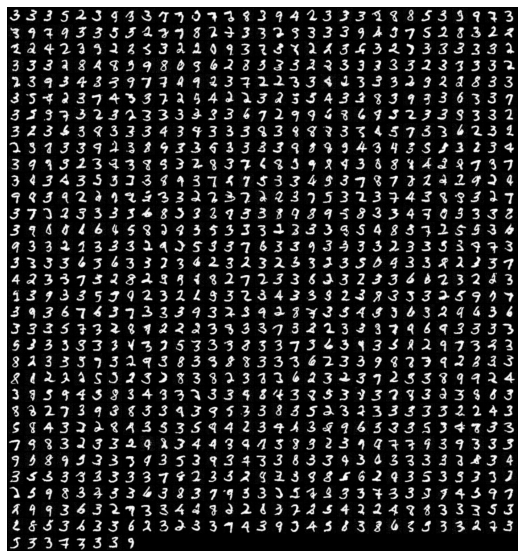

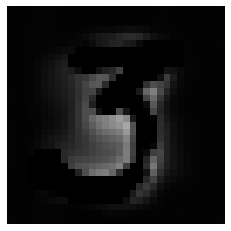

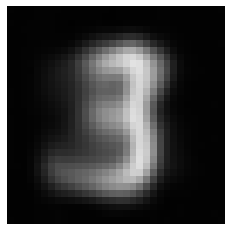

tensor(0.4182, device='cuda:0')


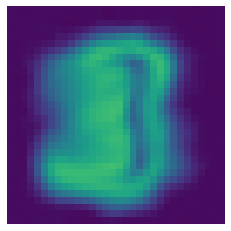

In [7]:
## Generate samples using the specified sampler.
start = time.time()
samples = LD_sampler(uncond_score_model, 
                  T,
                  y = y.repeat((sample_batch_size, 1, 1)).reshape((sample_batch_size, 1, A.shape[0])),
                  A = A.to(device).float(), 
                  Gam_inv = Gam_inv,
                  batch_size = sample_batch_size, 
                  num_steps = num_steps,
                  eps = eps,
                  size = size,
                  color_channels = 1,
                  device=device)

print("time elapsed:", time.time() - start)
## Sample visualization.
samples = samples.clamp(0.0, 1.0)
%matplotlib inline
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

std_ld = torch.std(samples, axis = 0)[0]
bias_ld = torch.mean(samples, axis = 0)[0] - true.to(samples.device)


plt.imshow(torch.mean(samples, axis = 0)[0].cpu().detach() - true.cpu().detach()[0][0], vmin=0., vmax=1., cmap = 'gray')
plt.grid(None) 
plt.axis('off')
plt.show()
plt.imshow(torch.mean(samples, axis = 0)[0].cpu().detach(), vmin=0., vmax=1., cmap = 'gray')
plt.grid(None) 
plt.axis('off')
plt.show()
plt.imshow(torch.std(samples, axis = 0)[0].cpu().detach(), vmin = 0., vmax = 0.6)
plt.grid(None) 
plt.axis('off')
print(torch.max(torch.std(samples, axis = 0)))

samples_ld = samples[0:9, :, :, :]

time elapsed: 1903.4685289859772


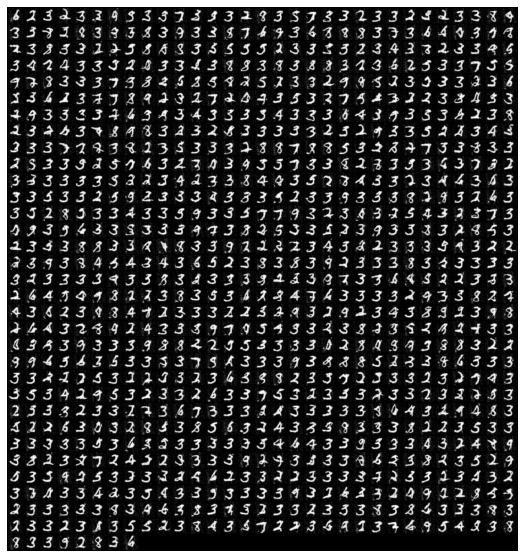

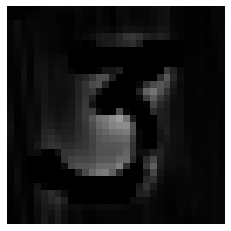

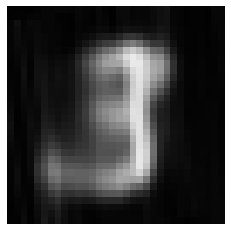

tensor(0.4005, device='cuda:0')


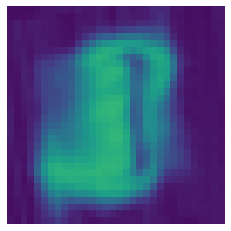

In [8]:
## Generate samples using the specified sampler.
start = time.time()
samples = ALD_sampler(uncond_score_model, 
                  T,
                  y = y.repeat((sample_batch_size, 1, 1)).reshape((sample_batch_size, 1, A.shape[0])),
                  A = A.to(device).float(), 
                  Gam_inv = Gam_inv,
                  batch_size = sample_batch_size, 
                  num_steps = num_steps,
                  eps = eps,
                  size = size,
                  color_channels = 1,
                  device=device)

print("time elapsed:", time.time() - start)
## Sample visualization.
samples = samples.clamp(0.0, 1.0)
%matplotlib inline
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

std_ald = torch.std(samples, axis = 0)[0]
bias_ald = torch.mean(samples, axis = 0)[0] - true.to(samples.device)


plt.imshow(torch.mean(samples, axis = 0)[0].cpu().detach() - true.cpu().detach()[0][0], vmin=0., vmax=1., cmap = 'gray')
plt.grid(None) 
plt.axis('off')
plt.show()
plt.imshow(torch.mean(samples, axis = 0)[0].cpu().detach(), vmin=0., vmax=1., cmap = 'gray')
plt.grid(None) 
plt.axis('off')
plt.show()
plt.imshow(torch.std(samples, axis = 0)[0].cpu().detach(), vmin = 0., vmax = 0.6)
plt.grid(None) 
plt.axis('off')
print(torch.max(torch.std(samples, axis = 0)))

samples_ald = samples[0:9, :, :, :]

time elapsed: 3776.3509044647217


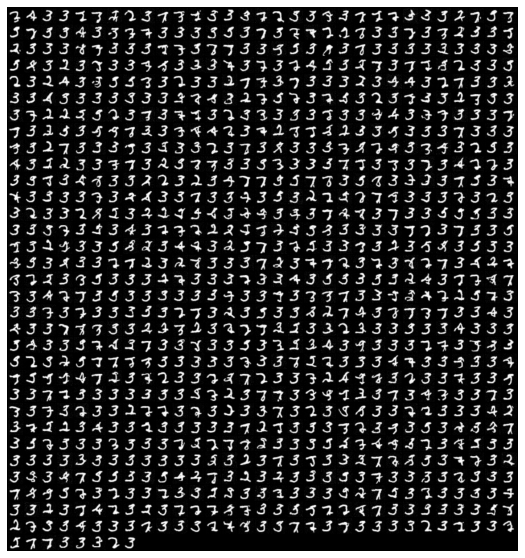

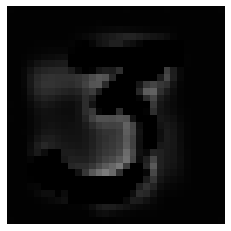

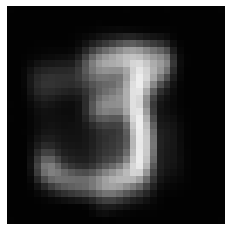

tensor(0.4465, grad_fn=<MaxBackward1>)


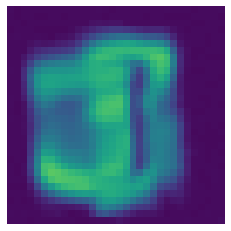

In [9]:
## Generate samples using the specified sampler.
start = time.time()

samples = torch.zeros(samples.shape)
num_samp = 0
while num_samp < sample_batch_size:
    curr_size = np.minimum(100, sample_batch_size - num_samp)
    samples[num_samp: num_samp + curr_size, :, :, :] = DPM_sampler(uncond_score_model, 
                      T,
                      y = y.repeat((curr_size, 1, 1)).reshape((curr_size, 1, A.shape[0])),
                      A = A.to(device).float(), 
                      Gam_inv = Gam_inv,
                      batch_size = curr_size, 
                      num_steps = num_steps,
                      eps = eps,
                      size = size,
                      color_channels = 1,
                      device=device)
    num_samp = num_samp + curr_size

std_dpm = torch.std(samples, axis = 0)[0]
bias_dpm = torch.mean(samples, axis = 0)[0] - true.to(samples.device)

print("time elapsed:", time.time() - start)
## Sample visualization.
samples = samples.clamp(0.0, 1.0)
%matplotlib inline
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()


plt.imshow(torch.mean(samples, axis = 0)[0].cpu().detach() - true.cpu().detach()[0][0], vmin=0., vmax=1., cmap = 'gray')
plt.grid(None) 
plt.axis('off')
plt.show()
plt.imshow(torch.mean(samples, axis = 0)[0].cpu().detach(), vmin=0., vmax=1., cmap = 'gray')
plt.grid(None) 
plt.axis('off')
plt.show()
plt.imshow(torch.std(samples, axis = 0)[0].cpu().detach(), vmin = 0., vmax = 0.6)
plt.grid(None) 
plt.axis('off')
print(torch.max(torch.std(samples, axis = 0)))

samples_dpm = samples[0:9, :, :, :]

time elapsed: 1977.6716403961182


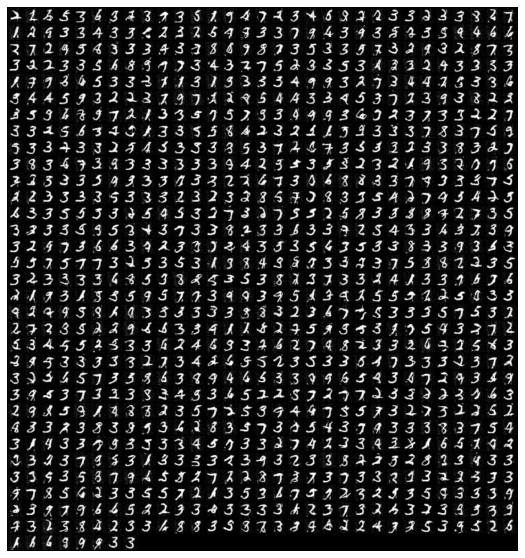

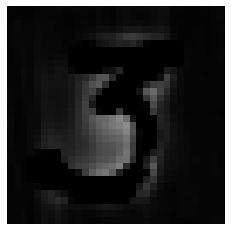

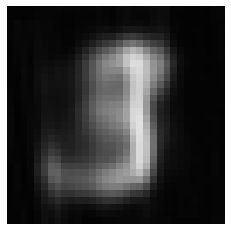

tensor(0.4164, device='cuda:0')


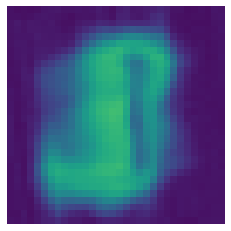

In [10]:
## Generate samples using the specified sampler.
start = time.time()
samples = Projection_sampler(uncond_score_model, 
                  lamb = 0.4,
                  T = T,
                  y = y.repeat((sample_batch_size, 1, 1)).reshape((sample_batch_size, 1, A.shape[0])),
                  A = A.to(device).float(), 
                  Gam_inv = Gam_inv,
                  batch_size = sample_batch_size, 
                  num_steps = num_steps,
                  eps = eps,
                  size = size,
                  color_channels = 1,
                  device=device)

print("time elapsed:", time.time() - start)
## Sample visualization.
samples = samples.clamp(0.0, 1.0)
%matplotlib inline
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

std_proj = torch.std(samples, axis = 0)[0]
bias_proj = torch.mean(samples, axis = 0)[0] - true.to(samples.device)


plt.imshow(torch.mean(samples, axis = 0)[0].cpu().detach() - true.cpu().detach()[0][0], vmin=0., vmax=1., cmap = 'gray')
plt.grid(None) 
plt.axis('off')
plt.show()
plt.imshow(torch.mean(samples, axis = 0)[0].cpu().detach(), vmin=0., vmax=1., cmap = 'gray')
plt.grid(None) 
plt.axis('off')
plt.show()
plt.imshow(torch.std(samples, axis = 0)[0].cpu().detach(), vmin = 0., vmax = 0.6)
plt.grid(None) 
plt.axis('off')
print(torch.max(torch.std(samples, axis = 0)))

samples_proj= samples[0:9, :, :, :]

time elapsed: 1901.2781133651733


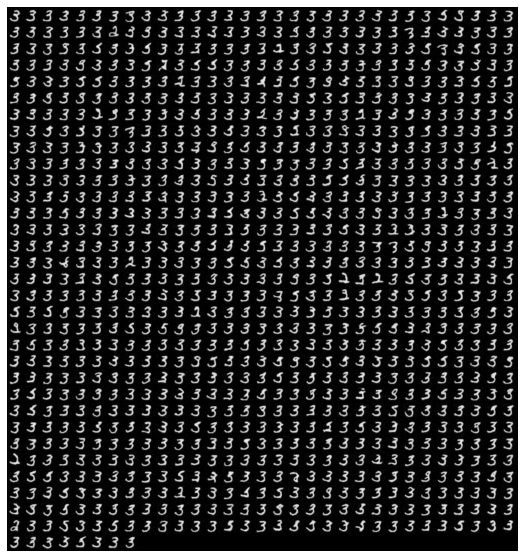

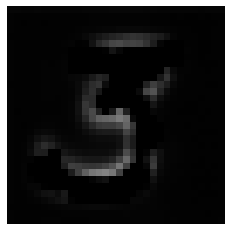

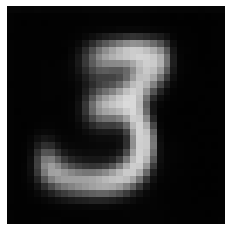

tensor(0.3369, device='cuda:0')


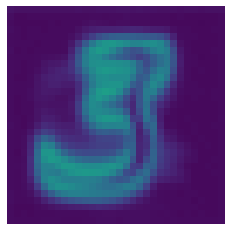

In [11]:
## Generate samples using the specified sampler.
start = time.time()
samples = Posterior_Euler_Maruyama_sampler(our_score_model, 
                  T = T,
                  y = y.repeat((sample_batch_size, 1, 1)).reshape((sample_batch_size, 1, A.shape[0])),
                  A = A.to(device).float(), 
                  Gam_inv = Gam_inv,
                  batch_size = sample_batch_size, 
                  size = size,
                  num_steps = num_steps,
                  color_channels = 1,
                  device=device,
                  eps = eps)

print("time elapsed:", time.time() - start)
## Sample visualization.
samples = samples.clamp(0.0, 1.0)
%matplotlib inline
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

std_ours = torch.std(samples, axis = 0)[0]
bias_ours = torch.mean(samples, axis = 0)[0] - true.to(samples.device)


plt.imshow(torch.mean(samples, axis = 0)[0].cpu().detach() - true.cpu().detach()[0][0], vmin=0., vmax=1., cmap = 'gray')
plt.grid(None) 
plt.axis('off')
plt.show()
plt.imshow(torch.mean(samples, axis = 0)[0].cpu().detach(), vmin=0., vmax=1., cmap = 'gray')
plt.grid(None) 
plt.axis('off')
plt.show()
plt.imshow(torch.std(samples, axis = 0)[0].cpu().detach(), vmin = 0., vmax = 0.6)
plt.grid(None) 
plt.axis('off')
print(torch.max(torch.std(samples, axis = 0)))

samples_ours = samples[0:9, :, :, :]

## Exporting images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


var of 45.69148635864258 for method ld
bias of 42.118446350097656 for method ld
var of 39.530670166015625 for method ald
bias of 36.9830322265625 for method ald
var of 45.80780792236328 for method dpm
bias of 26.62551498413086 for method dpm
var of 41.757694244384766 for method proj
bias of 39.141326904296875 for method proj
var of 18.494014739990234 for method ours
bias of 22.324481964111328 for method ours


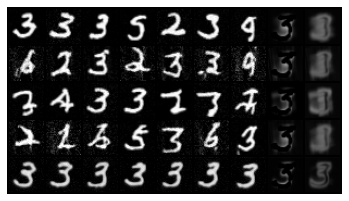

In [12]:
num_images = 7
max_std = 0.6
methods = ["ld", "ald", "dpm", "proj", "ours"]

samples = torch.zeros((num_images + 2) * len(methods), 1, size, size) 
biases = [bias_ld, bias_ald, bias_dpm, bias_proj, bias_ours]
stds = [std_ld, std_ald, std_dpm, std_proj, std_ours]
for method_number, samples_curr in enumerate([samples_ld, samples_ald, samples_dpm, samples_proj, samples_ours]):
    #std
    std = stds[method_number]
    samples[num_images + 1 + method_number * (num_images + 2)] = std
    print("var of "+ str(torch.sum(std**2).item()) + " for method " + methods[method_number])
    #bias
    bias = biases[method_number]
    samples[num_images + method_number * (num_images + 2)] = bias
    print("bias of "+ str(torch.sum(bias**2).item()) + " for method " + methods[method_number])
    ##truth
    #samples[7 + method_number * (num_images + 3)] = true
    #samples
    for ind in range(num_images):
        samples[ind + method_number * (num_images + 2), :, :, :] = samples_curr[ind, :, :, :]

sample_grid = make_grid(samples, nrow = (num_images + 2))
plt.grid(None) 
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.savefig("images/CT/summary.png", bbox_inches='tight')

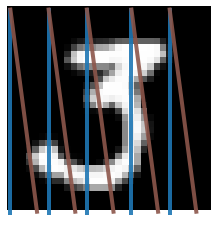

In [13]:
from skimage.transform import radon


# Perform the Radon transform
image = true.cpu().numpy()[0, 0, :, :]
theta = np.linspace(0., max_angle, angles, endpoint=False)
sinogram = y[0, :, :].cpu().numpy()

# Plot the original image with lines
plt.imshow(image, cmap=plt.cm.Greys_r)
plt.axis('off')
#plt.title('Original Image with Radon Transform Lines')

# Calculate the starting point for lines
start_x = 0 
start_y = 0  
num_lines = 5

# Overlay lines corresponding to the Radon transform
for i, angle in enumerate(theta):
    thetad = np.deg2rad(angle)
    diag_len = size
    x = np.linspace(-start_x, diag_len - start_x, sinogram.shape[0]) * np.cos(thetad) + start_x
    y = np.linspace(start_y, diag_len + start_y, sinogram.shape[0]) * np.sin(thetad)
    colors = plt.cm.tab10(i / len(theta))  # Use a colormap to choose different colors for different angles
    for line in range(num_lines):
        plt.plot(y + size * line // num_lines, x, color=colors, linewidth=4, alpha=0.9)

plt.savefig("images/CT/groundtruth_with_radon_lines.png", bbox_inches='tight')
plt.show()

# Plot the sinogram
plt.imshow(sinogram / np.max(sinogram), cmap='gray')
plt.axis('off')

#plt.title('Sinogram')

# Plot the sinogram with colors corresponding to the lines in the original image
for col in range(sinogram.shape[1]):
    color_index = int(col / sinogram.shape[1] * len(theta))
    color = plt.cm.tab10(color_index / len(theta))
    plt.plot([col, col], [0, sinogram.shape[0]], color=color, linewidth=4, alpha = 0.8)

plt.savefig("images/CT/measurement.png", bbox_inches='tight')
plt.show()
